In [1]:
### Imports

import matplotlib.pyplot as plt
plt.rc('font',family='AppleGothic')
import numpy as np
import pandas as pd

In [2]:
# Load_data

data_raw = pd.read_csv('../used/data/raw_data/train.csv')
sample_submission_raw = pd.read_csv('../used/data/raw_data/sample_submission.csv')

data=data_raw.copy()
sample_submission=sample_submission_raw.copy()

In [3]:
# Data_index to timeseries

data.set_index('일시',inplace=True)
data.index=pd.to_datetime(data.index,format='%Y%m%d')
data['week']=data.index.isocalendar().week
data['day_name']=data.index.weekday
data['weekend']=data['day_name'].apply(lambda x: 0 if x<5 else 1)
data['year']=data.index.year

## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 

sample_submission.set_index('일시',inplace=True)
sample_submission.index=pd.to_datetime(sample_submission.index,format='%Y%m%d')
sample_submission['week']=sample_submission.index.isocalendar().week
sample_submission['day_name']=sample_submission.index.weekday
sample_submission['weekend']=sample_submission['day_name'].apply(lambda x: 0 if x<5 else 1)
sample_submission['year']=sample_submission.index.year

In [4]:
# 년도별 공휴일 체크하기위한 library => 평일인 공휴일도 주말로 설정.

from pytimekr import pytimekr
def get_holiday(_year):
    holidays=[]
    for holiday in pytimekr.holidays(year=_year):
        if pytimekr.red_days(holiday) != None:
            ans = [i.strftime("%Y-%m-%d") for i in pytimekr.red_days(holiday)]
            holidays.extend(ans)
        else:
            ans=holiday.strftime("%Y-%m-%d")
            holidays.append(ans)
    return list(set(holidays))

data.loc[get_holiday(2018),'weekend'] = 1
data.loc[get_holiday(2019),'weekend'] = 1
data.loc[get_holiday(2020),'weekend'] = 1
data.loc[get_holiday(2021),'weekend'] = 1
sample_submission.loc[sorted(get_holiday(2022))[:-1],'주말평일'] ='주말'

In [8]:
data

광진구   동대문구    성동구    중랑구  week  day_name  weekend  year
일시                                                                   
2018-01-01  0.592  0.368  0.580  0.162     1         0        1  2018
2018-01-02  0.840  0.614  1.034  0.260     1         1        0  2018
2018-01-03  0.828  0.576  0.952  0.288     1         2        0  2018
2018-01-04  0.792  0.542  0.914  0.292     1         3        0  2018
2018-01-05  0.818  0.602  0.994  0.308     1         4        0  2018
...           ...    ...    ...    ...   ...       ...      ...   ...
2021-12-27  3.830  3.416  2.908  2.350    52         0        0  2021
2021-12-28  4.510  3.890  3.714  2.700    52         1        0  2021
2021-12-29  4.490  3.524  3.660  2.524    52         2        0  2021
2021-12-30  4.444  3.574  3.530  2.506    52         3        0  2021
2021-12-31  3.616  3.210  2.620  2.146    52         4        0  2021

[1461 rows x 8 columns]

In [5]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [6]:
# 년도별 주별 (평일,주말) 별 평균값 구하기
data_week_groupby=data.groupby(['year','week','weekend']).mean().reset_index()

In [7]:
# 년도별 주별 (평일,주말) 별 평균값 구하기
df_2018=data_week_groupby[data_week_groupby['year']==2018].iloc[:,[1,2,3,4,5,6]]
df_2019=data_week_groupby[data_week_groupby['year']==2019].iloc[:,[1,2,3,4,5,6]]
df_2020=data_week_groupby[data_week_groupby['year']==2020].iloc[:,[1,2,3,4,5,6]]
df_2021=data_week_groupby[data_week_groupby['year']==2021].iloc[:,[1,2,3,4,5,6]]

In [8]:
# 주말평일의 갭이 너무 불연속 적이라 smoothing 진행

year_df_list=[df_2018,df_2019,df_2020,df_2021]
for df in year_df_list:
    for col in df.iloc[:,2:].columns:
        df[col] = smooth(df[col],7)

In [9]:
# 각 연도별 minmaxscaling 진행
## => 모든 연도별 주간 평균을 값을 baseline으로 2022년을 예측하기 위해
from sklearn.preprocessing import MinMaxScaler
mms_2018 = MinMaxScaler()
mms_2019 = MinMaxScaler()
mms_2020 = MinMaxScaler()
mms_2021 = MinMaxScaler()

# 각 연도별 minmaxscaling 진행
year_df_list=[df_2018,df_2019,df_2020,df_2021]
scaler_list=[mms_2018,mms_2019,mms_2020,mms_2021]
for df,mms in zip(year_df_list,scaler_list):
    df.iloc[:,2:] = mms.fit_transform(df.iloc[:,2:])

In [11]:
# 연도별 대여량을 스케일링 한후 주별,(평일,주말별) 대여량 평균구하기
week_mean=pd.concat(year_df_list).\
    groupby(['week','weekend']).mean().reset_index()

In [12]:
week_mean

week  weekend       광진구      동대문구       성동구       중랑구
0       1        0  0.000000  0.000000  0.000000  0.000000
1       1        1  0.034379  0.036138  0.037351  0.027567
2       2        0  0.069503  0.071094  0.073133  0.059770
3       2        1  0.105487  0.109272  0.112585  0.090830
4       3        0  0.099792  0.101856  0.104050  0.088229
..    ...      ...       ...       ...       ...       ...
101    51        1  0.197307  0.235297  0.191927  0.212765
102    52        0  0.131153  0.158553  0.124878  0.148527
103    52        1  0.091892  0.118654  0.092212  0.110412
104    53        0  0.028854  0.074243  0.051411  0.062857
105    53        1  0.088068  0.091297  0.072824  0.093768

[106 rows x 6 columns]

In [13]:
# 이제 minmaxscaling된 자료를 바탕으로 
# 각 년도에 맞게 inverse_transform 진행 => 2018년도 스케일의 (주간평균), 2019년도 스케일의 (주간평균),2020년도 스케일의 (주간평균),2021년도 스케일의 (주간평균)
df_2018_weekmean=pd.DataFrame(mms_2018.inverse_transform(week_mean.iloc[:,2:]),columns=week_mean.iloc[:,2:].columns)
df_2018_weekmean['week'] = week_mean['week']
df_2018_weekmean['weekend'] = week_mean['weekend']
df_2019_weekmean=pd.DataFrame(mms_2019.inverse_transform(week_mean.iloc[:,2:]),columns=week_mean.iloc[:,2:].columns)
df_2019_weekmean['week'] = week_mean['week']
df_2019_weekmean['weekend'] = week_mean['weekend']
df_2020_weekmean=pd.DataFrame(mms_2020.inverse_transform(week_mean.iloc[:,2:]),columns=week_mean.iloc[:,2:].columns)
df_2020_weekmean['week'] = week_mean['week']
df_2020_weekmean['weekend'] = week_mean['weekend']
df_2021_weekmean=pd.DataFrame(mms_2021.inverse_transform(week_mean.iloc[:,2:]),columns=week_mean.iloc[:,2:].columns)
df_2021_weekmean['week'] = week_mean['week']
df_2021_weekmean['weekend'] = week_mean['weekend']

In [14]:
# 각 location별 2022값 년도별 diff 차이를 활용하여, 계산
df_2021_weekmean.iloc[:,0]=df_2021_weekmean.iloc[:,0]+pd.concat([df_2018_weekmean.iloc[:,0],df_2019_weekmean.iloc[:,0],df_2020_weekmean.iloc[:,0],df_2021_weekmean.iloc[:,0]],axis=1).diff(axis=1).mean(axis=1)*3
df_2021_weekmean.iloc[:,1]=df_2021_weekmean.iloc[:,1]+pd.concat([df_2018_weekmean.iloc[:,1],df_2019_weekmean.iloc[:,1],df_2020_weekmean.iloc[:,1],df_2021_weekmean.iloc[:,1]],axis=1).diff(axis=1).mean(axis=1)*3
df_2021_weekmean.iloc[:,2]=df_2021_weekmean.iloc[:,2]+pd.concat([df_2018_weekmean.iloc[:,2],df_2019_weekmean.iloc[:,2],df_2020_weekmean.iloc[:,2],df_2021_weekmean.iloc[:,2]],axis=1).diff(axis=1).mean(axis=1)*3
df_2021_weekmean.iloc[:,3]=df_2021_weekmean.iloc[:,3]+pd.concat([df_2018_weekmean.iloc[:,3],df_2019_weekmean.iloc[:,3],df_2020_weekmean.iloc[:,3],df_2021_weekmean.iloc[:,3]],axis=1).diff(axis=1).mean(axis=1)*3

<AxesSubplot: >

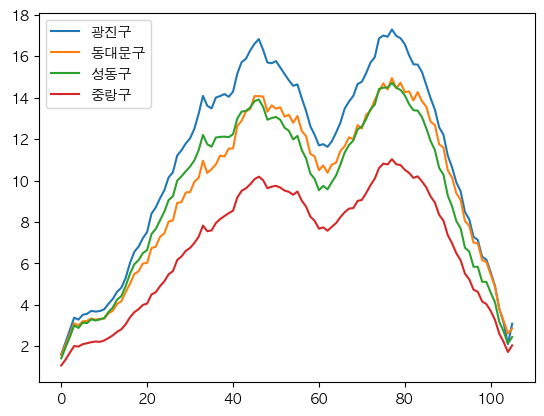

In [15]:
df_2021_weekmean.iloc[:,:4].plot()

In [16]:
# submit
sample_submission['week']=sample_submission['week'].apply(lambda x: 1 if x == 52 else x )
ans=sample_submission.merge(df_2021_weekmean,on=['week','weekend']).iloc[:,-4:]
sample_submission_raw.iloc[:,1:] = ans.values
sample_submission_raw.to_csv('final_ans.csv',index=False)